In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import networkx as nx
#from nxviz.plots import CircosPlot
import operator
from operator import itemgetter
import pandas as pd
from PIL import Image
import networkx as nx
from matplotlib import pyplot, patches,axes
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from glob import glob
import seaborn as sns
import scipy
from nilearn import plotting
import nibabel as nib
from brainspace.utils.parcellation import map_to_labels, relabel
from nilearn.surface import vol_to_surf
from nilearn import datasets 
from nilearn.connectome import ConnectivityMeasure
from nilearn.datasets import MNI152_FILE_PATH
from nilearn import plotting
from nilearn.interfaces.fmriprep import load_confounds_strategy
import nibabel as nib
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69


#### Function

In [2]:
def cut_cerebellum(matrix):
    # remove cerebellum 
    matrix_ = []
    for i in range(len(matrix)):
        matrix_.append(np.delete(matrix[i],[14,15,16]))
    return matrix_

In [3]:
def normalize_series(series):
    mean = np.mean(series)
    std = np.std(series)
    normalized_series = (series - mean) / std
    return normalized_series

#### Load file

In [4]:
mat_file_name = "/data/camin/yrjang/HCP_data/HCP/timeseries/"
file_list = os.listdir(mat_file_name)
file_list_py = [file for file in file_list if file.endswith('.mat')]

In [12]:
mat_file = []
mat_file_name = "/data/camin/yrjang/HCP_data/HCP/timeseries/"
file_list = os.listdir(mat_file_name)
file_list_py = [file for file in file_list if file.endswith('.mat')]
for i in file_list_py[:20]:
    print(i)
    mat_file_ = scipy.io.loadmat(mat_file_name + i)
    mat_file.append(mat_file_)

100206.mat
100307.mat
100408.mat
164939.mat
144226.mat
122822.mat
100610.mat
165032.mat
144428.mat
123117.mat
101006.mat
165436.mat
123420.mat
144731.mat
101107.mat
165638.mat
123521.mat
144832.mat
101309.mat
165840.mat


In [8]:
len(mat_file)

100

In [9]:
np.save('/data/camin/yrjang/HCP_data/20subject.npy',mat_file)

In [5]:
mat_file = np.load('/data/camin/yrjang/HCP_data/20subject.npy', allow_pickle=True)

### Load subject info

In [6]:
# 파일명
file_name = '/data/Database/HCP/S1200_total.xlsx'
pd.set_option('display.max_columns', None)

# Daraframe형식으로 엑셀 파일 읽기
df = pd.read_excel(file_name,engine='openpyxl')

In [7]:
temp = df.to_numpy()

In [8]:
phenoInfos = {}
for row in temp:
    phenoInfos[str(row[0])] = {"age" : row[1], "gender" : row[2]}

In [13]:
roi = 3
dataset=[]
for i, data in enumerate(mat_file):
    # extract Schaefer300 - session 1,2 (LR,RL)
    s1_LR = data['FC_ts'][0][0][0][0][0][roi+2]
    s1_RL = data['FC_ts'][0][0][1][0][0][roi+2]
    s2_LR = data['FC_ts'][0][0][2][0][0][roi+2]
    s2_RL = data['FC_ts'][0][0][3][0][0][roi+2]
    
    # cut 17
    s1_LR_= cut_cerebellum(s1_LR)
    s1_RL_= cut_cerebellum(s1_RL)
    s2_LR_= cut_cerebellum(s2_LR)
    s2_RL_= cut_cerebellum(s2_RL)
    
    nmal_s1_LR = normalize_series(s1_LR_)
    nmal_s1_RL = normalize_series(s1_RL_)
    nmal_s2_LR = normalize_series(s2_LR_)
    nmal_s2_RL = normalize_series(s2_RL_)
    
    roiTimeseries = np.concatenate([nmal_s1_LR,nmal_s1_RL,nmal_s2_LR,nmal_s2_RL])
    subjectId = file_list_py[:100][i].split(".")[0]
    
    dataset.append({
                "roiTimeseries": roiTimeseries,
                "pheno": {"subjectId" : subjectId , **phenoInfos[subjectId ]}})

/home/yrjang/.local/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:327: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


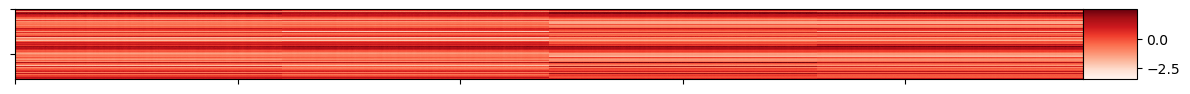

In [14]:
corr_plot = plotting.plot_matrix(np.array(roiTimeseries).T, figure=(12, 5), labels=None, cmap='Reds')

In [22]:
np.array(s1_LR_).T[0]

array([12474.79345703, 12460.54591619, 12464.32067649, ...,
       12526.81300604, 12590.99889027, 12524.58571555])

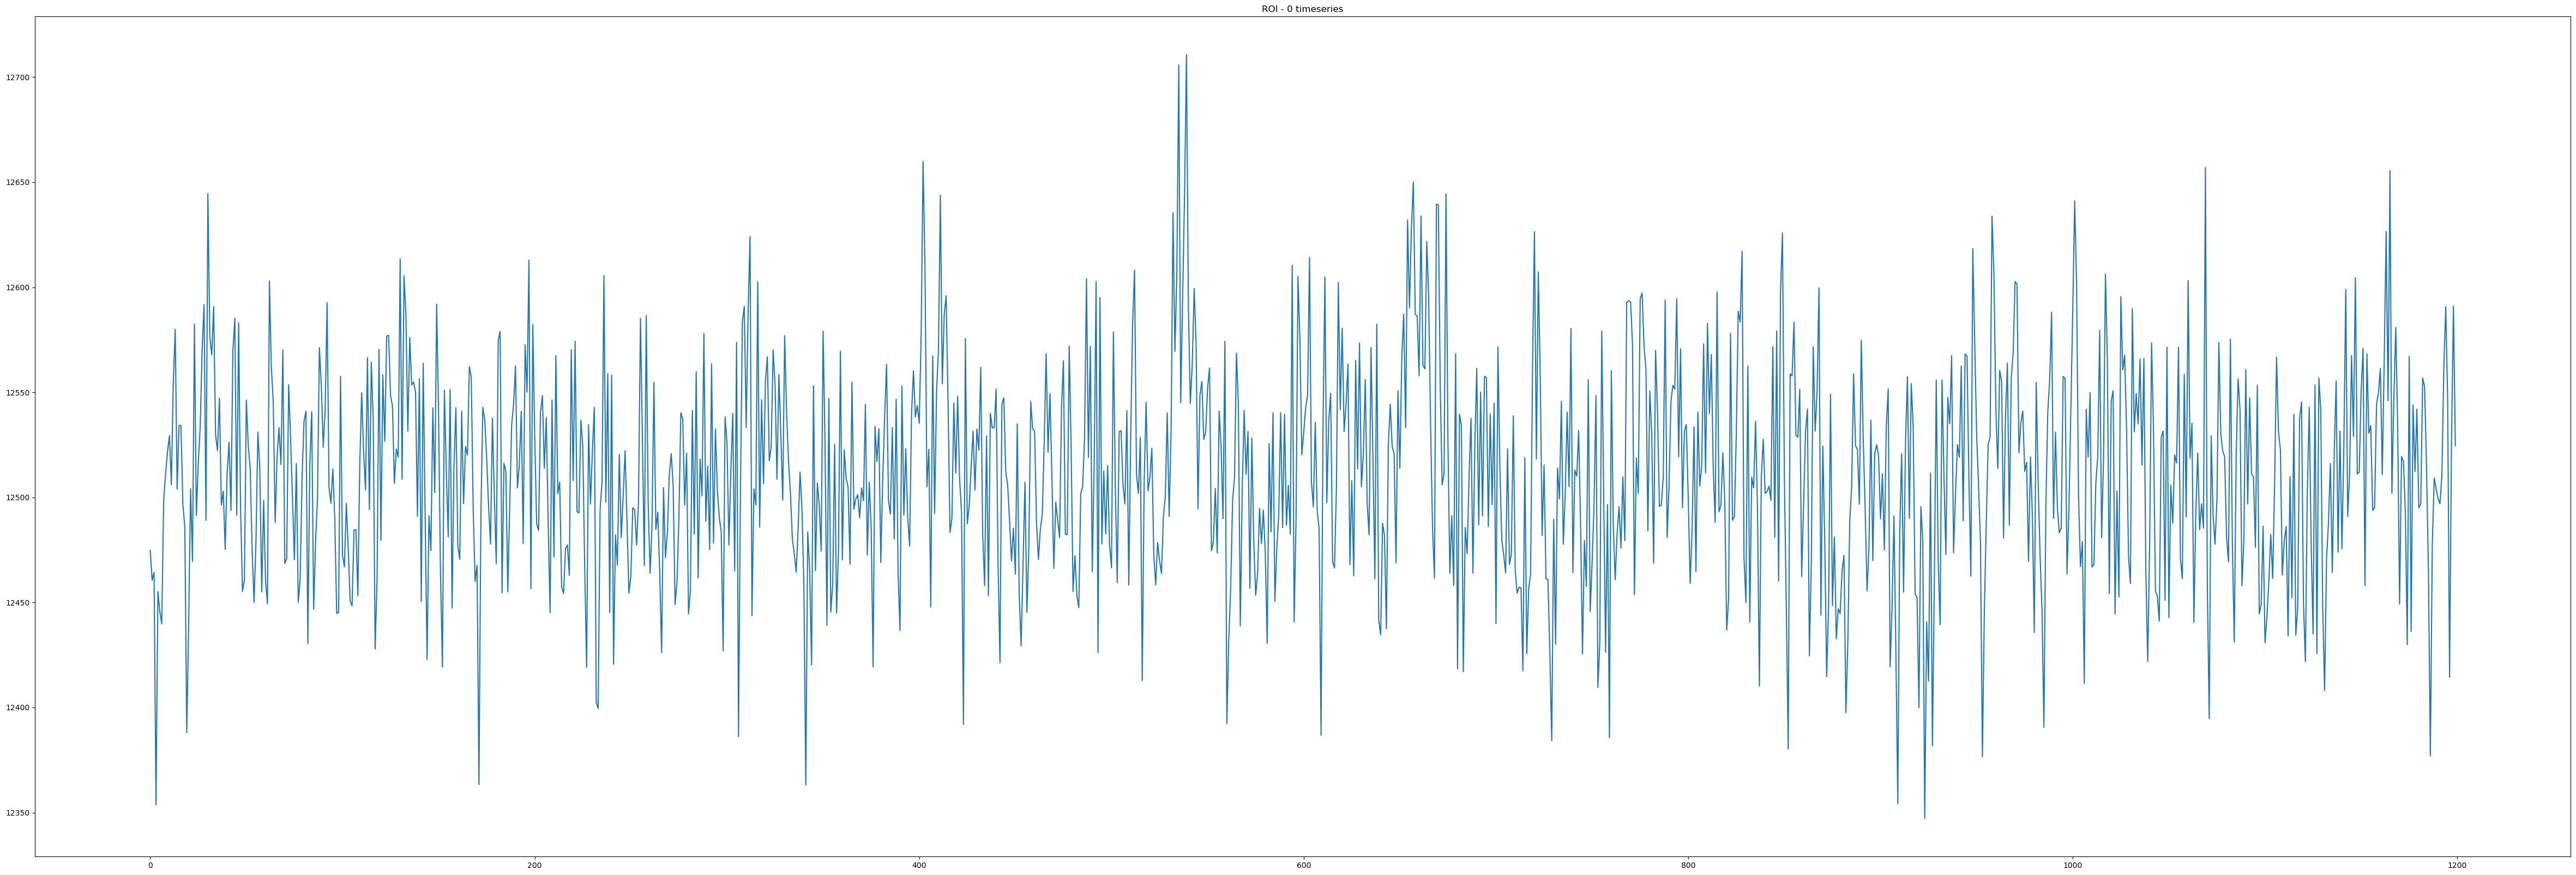

In [31]:
x = np.arange(0,1200)
y = np.array(s1_LR_).T[0]

plt.figure(figsize=(60,20))
plt.plot(x,y)
plt.title("ROI - 0 timeseries")
plt.show()

In [11]:
np.array(dataset).shape

(100,)

In [15]:
np.save('/data/camin/yrjang/HCP_data/HCP_300_data_sub20.npz',dataset)

In [16]:
dataset[0]['roiTimeseries'].shape

(4800, 314)